# Comparing Natural Language Processing Approaches to Clustering Patents from Subsidiary Companies
## Peter de Guzman (ped19)
## Lilah DuBoff (lad90)
## Christian Moreira (csm87)

## Problem Statement:

Using a dataset of patents submitted to the U.S. Patent Office(USPTO) by subsidiaries of large multinational corporations, we will perform clustering of patents into patent topic categories. Some of the NLP techniques employed in this assignment include performing data cleaning on patent text, performing dimension reduction using PCA and machine learning algorithms(Complement Naive Bayes and Support Vector Classifier) for clustering patent abstracts and titles into a set of relevant comparable topics. The motivation behind this work is to address the task of tracking innovation across publicly traded companies, especially where patents are filed under different subsidiary names(i.e. “Google” with patents under “Waymo”, “DeepMind”, “Nest”); Emerging technological advancements often occur under subsidiaries of large corporations, but are not tracked due to the multitude of subsidiary firms. This project explores classification methods beyond the traditional Cooperative Patent Classification (CPC) system, offering more flexible and insightful ways for legal specialists, researchers, and investors to explore patent content and similar innovation strategies.


## Solution:

Large publicly traded companies are constantly innovating and investing millions of dollars in research and development to maintain a competitive edge in the marketplace while developing new products. The patents during the innovation process are often filed by the subsidiaries of these large companies. Informed investors and attorneys rely on alternative patent data to track the actions of these subsidiaries and better understand emerging trends and forecast growth across industries, but manually tracking patents can be resource intensive due to complex corporate structures between parent companies and subsidiaries. Oftentimes a large publicly traded company could have dozens to hundreds of subsidiaries, each filing patents under a separate entity. Targeting subsidiary companies requires name mapping solutions that can parse large amounts of patent data and establish connections between seemingly disparate corporate entities. For investors, scientists, and legal advisors it is instrumental to be able to quickly track a patent for a company while also evaluating novel inventions in strategic areas of the industries in which they operate. 

To address this, we tested the ability of two models that cluster patent text content (title and abstracts) into meaningful groups by topic. For cluster evaluation we compare model clusters to IPC Sections and Classes (see Exhibit 1 for an example of this). The models implemented in this experiment use two supervised techniques: a Complement Naive Bayes classifier and a support vector classifier (SVC) model. Both models were trained on a dataset of patent documents and evaluated using standard clustering metrics such as accuracy,predictions, and recall; Before classification the data is preprocessed to remove distracting terms(filler words) or combine  terms together (plural nouns i.e. box & boxes). The model evaluation adheres occurs relative to its actual classification group which is a combination of patent section and class. 

![PatentTaxonomy]("PatentTaxonomy.png")

insert image 2

The Complement Naive Bayes classifier (or ComplementNB) is a supervised, probabilistic linear model modified from a multinomial Naive Bayes model. In the real patent data, classes are often highly imbalanced - some sections appear far more frequently than others. ComplementNB is designed to perform well on imbalanced text data, as it estimates feature weights for sparser classes, which reduces model bias and stabilizes predictions across different class types. It completes this by assuming conditional independence between words, and relying on frequency-based computations. The combination of these strategies makes the model robust, even on messy or imbalanced data, making it a strong choice for patent classifications.

The support vector classifier (or LinearSVC) is another supervised machine learning model, but instead of looking at how often words appear in each class, like ComplementNB does, LinearSVC learns which combinations of words best separate one IPC section from another. For patent data, this is effective because Linear SVC can pick up on more complex and detailed language patterns in titles and abstracts. The drawback is that LinearSVC is less interpretable, and takes longer to train (marginal with the amount of data we have, but important to note for scalability and cost-efficiency). Overall, it typically outperforms a text classifying Naive Bayes model, therefore it is important to compare both to contextualize accuracy and efficiency in patent classification.


# Evaluation of Training Results

In [17]:
# Load in libraries and data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# UPDATE: Added CountVectorizer here
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.metrics import classification_report, accuracy_score
import re
import math
from sklearn.decomposition import PCA
import warnings
from tabulate import tabulate
import numpy as np

warnings.filterwarnings("ignore")

In [18]:
#PREPROCESSING CODE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# makes everything lowercase, removes punctuation, lemmatizes, and removes stopwords
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = " ".join([lemmatizer.lemmatize(word) for word in t.split() if word not in stop])
    return t

# load in new subset
df_subset = pd.read_csv("data/top500_patents.csv")

# combine section and class, then clean text
df_subset["Combined_ipc_clean"] = (
    df_subset["ipc_sections"] + "_" + df_subset["ipc_classes"].astype(str)
)

# combine title and abstract for easier classification
df_subset["text_clean"] = (
    (df_subset["patent_title"] + ": " + df_subset["patent_abstract"])
    .astype(str)
    .apply(clean_text)
)

#Additional Data Cleaning

# drop under 50 observations
df_subset = df_subset.groupby("Combined_ipc_clean").filter(lambda x: len(x) >= 50)

# remove the duplicate rows
dups_to_remove = ["H_4", "G_1", "B_1", "G_6", "C_7"]
for dup in dups_to_remove:
    df_subset = df_subset[df_subset["Combined_ipc_clean"] != dup]

## Generating Synthetic Data from CNB Conditional Word Distributions Learned From Real Data

In [19]:
#train CNB on our real data so we can generate the synthetic data

#Use inputs and labels from the real dataset
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

#Perform the train-test split
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y_bayes, random_state=42
)

#Use CountVectorizer and fit the model
vec = CountVectorizer(stop_words="english", max_features=50000)
X_train_vec = vec.fit_transform(X_train_bayes)
X_test_vec = vec.transform(X_test_bayes)

cnb = ComplementNB()
cnb.fit(X_train_vec, y_train_bayes)

#Evaluate the CNB model on real data
preds = cnb.predict(X_test_vec)
report_dict_realdata = classification_report(
    y_test_bayes, preds, output_dict=True
)


In [20]:
#Creating a CNB-Based way to generate synthetic text from the model's learned conditional word distributions

#compute class priors from real data

class_counts = y_train_bayes.value_counts()
class_priors = class_counts / class_counts.sum()
#print("Real class priors:")
#print(class_priors)

def sample_docs_from_cnb_with_real_priors(
    cnb, 
    vectorizer, 
    class_priors,
    n_total_docs=5000,
    doc_len_range=(50, 120)
):
    
    classes = cnb.classes_
    vocab = vectorizer.get_feature_names_out()

    #normalize
    raw_probs = np.exp(cnb.feature_log_prob_)
    word_probs = raw_probs / raw_probs.sum(axis=1, keepdims=True)

    synthetic_labels = np.random.choice(
        class_priors.index, 
        size=n_total_docs, 
        p=class_priors.values
    )

    synthetic_texts = []

    for cls in synthetic_labels:
        # find  index (number) 
        c_index = np.where(classes == cls)[0][0]

        # probability distribution for words
        p_w_given_c = word_probs[c_index]

        # sample doc len
        L = np.random.randint(*doc_len_range)

        # sample word indices
        sampled_idx = np.random.choice(
            len(vocab),
            size=L,
            replace=True,
            p=p_w_given_c
        )

        # convert to tokens
        doc_words = [vocab[i] for i in sampled_idx]
        synthetic_texts.append(" ".join(doc_words))

    return pd.Series(synthetic_texts), pd.Series(synthetic_labels)

# Generate the synthetic dataset
X_syn, y_syn = sample_docs_from_cnb_with_real_priors(
    cnb=cnb,
    vectorizer=vec,
    class_priors=class_priors,
    n_total_docs=10000,     #going to make a lot
    doc_len_range=(50, 120)
)

#print("Synthetic dataset size:", len(X_syn))
#print("Per-class counts:")
#print(y_syn.value_counts())

#print("Synthetic class distribution:")
#print(y_syn.value_counts(normalize=True))

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Vectorize synthetic text using same vocabulary
X_syn_vec = vec.transform(X_syn)

X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn_vec, y_syn, test_size=0.2, stratify=y_syn, random_state=42
)

# Train CNB on synthetic data
cnb_synth = ComplementNB()
cnb_synth.fit(X_train_syn, y_train_syn)

# Train SVC on synthetic data
svc_synth = LinearSVC()
svc_synth.fit(X_train_syn, y_train_syn)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [ ]:
from sklearn.metrics import accuracy_score

cnb_acc = cnb_synth.score(X_test_syn, y_test_syn)
svc_acc = svc_synth.score(X_test_syn, y_test_syn)

print("Synthetic Data Performance:")
print(f"CNB accuracy: {cnb_acc:.4f}")
print(f"SVC accuracy: {svc_acc:.4f}")

Synthetic Data Performance:
CNB accuracy: 0.5030
SVC accuracy: 0.4760


# Application of Solution on Real Data

To conduct this experiment, we collected publicly available patent data from the U.S. Patent and Trademark Office (USPTO). First, we researched the thirty companies listed in the Dow Jones Industrial Average, a stock market index of prominent companies. Referencing this list, we collected the legal incorporated names of subsidiaries for each large company. Finally, we used this list of subsidiary names as input for the USPTO API which returned the patent title and abstract for each subsidiary company. 

We conducted multiple data pre-processing steps to clean the data and improve accuracy. First, we removed duplicate patent observations. We also combined the “class” and “section” labels for each patent to produce more meaningful clusters. Both the “class” and “section” labels identify patents by industry field and topic. We additionally subset the data to only predict classes that have more than fifty observations. As patent classifications can be very niche, we expect to observe many patents that have multiple classifications but only one or two observations. This sort of data does not typically perform well for machine learning problems, so we dropped them. 

We also performed multiple steps to make the text easier to classify. We first converted all text to lowercase and used the Python Natural Language Toolkit (“nltk”) package to remove stopwords such as “the”, “and”, etc. We also used a lemmatizer which converts all the words in our dataset to their dictionary form (a lemma). This improves the accuracy by treating words with similar meanings the same, reducing data redundancy and making the text more consistent. Finally, to quicken the training process and reduce the compute load on our machines, we reduced the dataset to the most recent 500 patents. We then created training and test splits from this smaller dataset.


**Complement Naive Bayes Classifier:**

In the Complement Naive Bayes pipeline, we also use the TF-IDF vectorizer, as above. 

After these preprocessing steps, the ComplementNB classifier achieved an overall accuracy of 69%. Given the 47 classes in our dataset and the imbalanced nature of patent classification, this performance exceeded our expectations. 

The macro average F1 score, which treats classes equally, was 51%. This indicates that we have imbalance issues in our dataset. The weighted F1 score, which accounts for imbalance by weighing each class by how frequent it is, was 65%. Since the weighted average is high, we can conclude that the model performed well on classes that are more common. However, the macro average was much lower, displaying that the model performs poorly on rare classes. When reviewing the classification report below, we can observe that the F1 score was consistently higher for classes with more support, or a higher number of true samples in the class. This matches our expectation that the model’s metrics are more stable for classes with more support. Poor results occurred more often for classes with support of fewer than 20 observations. 


In [23]:
# Multinomial Naive Bayes Classifier
# Inputs and labels
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y_bayes, random_state=42
)

# Build model
# UPDATE: Swapped TF-IDF for CountVectorizer
class_model = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english", max_features=50000)),
        ("nb", ComplementNB()),
    ]
)

# Train
class_model.fit(X_train_bayes, y_train_bayes)

# Evaluate
preds = class_model.predict(X_test_bayes)

# Compute report as dict
report_dict_realdata_cnb = classification_report(y_test_bayes, preds, output_dict=True)

# Convert to DataFrame
report_df_real_cnb = pd.DataFrame(report_dict_realdata_cnb).transpose()

# Round numbers for readability
report_df_real_cnb = report_df_real_cnb.round(4)

# print("Real Data Results (CountVectorizer):")
# print(tabulate(report_df_real_cnb, headers='keys', tablefmt='grid'))

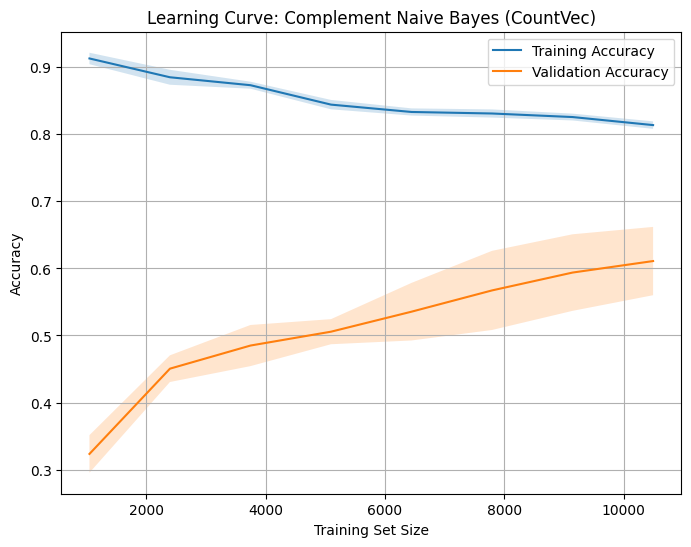

In [24]:
# Visualize the learning curve
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
# UPDATE: Ensure CountVectorizer is imported if running this cell independently
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np


def plot_learning_curve(estimator, title, X, y):
    plt.figure(figsize=(8, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8),
        scoring="accuracy",
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")

    # Train accuracy
    plt.plot(train_sizes, train_mean, label="Training Accuracy")
    plt.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2
    )

    # Validation accuracy
    plt.plot(train_sizes, test_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.legend()
    plt.grid(True)
    plt.show()


# Create models
# UPDATE: Swapped TF-IDF for CountVectorizer
svc_model = Pipeline(
    [("vec", CountVectorizer(stop_words="english")), ("clf", LinearSVC())]
)

# UPDATE: Swapped TF-IDF for CountVectorizer
cnb_model = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english", max_features=50000)),
        ("nb", ComplementNB()),
    ]
)

# Plot learning curves
plot_learning_curve(cnb_model, "Learning Curve: Complement Naive Bayes (CountVec)", X_bayes, y_bayes)

As we can see from the above plot, as the training set size increases, the training accuracy drops and the validation accuracy for the model grows. This aligns with our expectations because Complement Naive Bayes is a high-bias and low-variance model like its other Naive Bayes peers. When the training data is small, the model can overfit to the word distributions. As the training dataset size increases, the model overfits less, reducing training accuracy but increasing validation accuracy because the distribution estimates improve. In particular, Complement Naive Bayes is designed to benefit from more data, and this positive growth in validation accuracy with more training data can be observed above. 

**Support Vector Classifier:**

In [25]:
# SVC code
# Define X and y
X_svc = df_subset["text_clean"]
y_svc = df_subset["Combined_ipc_clean"]

# Train/test split
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(
    X_svc, y_svc, test_size=0.2, stratify=y_svc, random_state=42
)

# LinearSVC model
# UPDATE: Swapped TF-IDF for CountVectorizer
svc_model_real = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("clf", LinearSVC(class_weight="balanced")),
    ]
)

# Fit model
svc_model_real.fit(X_train_svc, y_train_svc)

# Predictions
y_pred_svcreal= svc_model_real.predict(X_test_svc)

# Evaluation
# Compute report as dict
report_dict_realdata_svc = classification_report(y_test_svc, y_pred_svcreal, output_dict=True)

# Convert to DataFrame
report_df_real_svc = pd.DataFrame(report_dict_realdata_svc).transpose()

# Round numbers for readability
report_df_real_svc = report_df_real_svc.round(4)

#print("Real Data Results - SVC (CountVectorizer):")
#print(tabulate(report_df_real_svc, headers='keys', tablefmt='grid'))

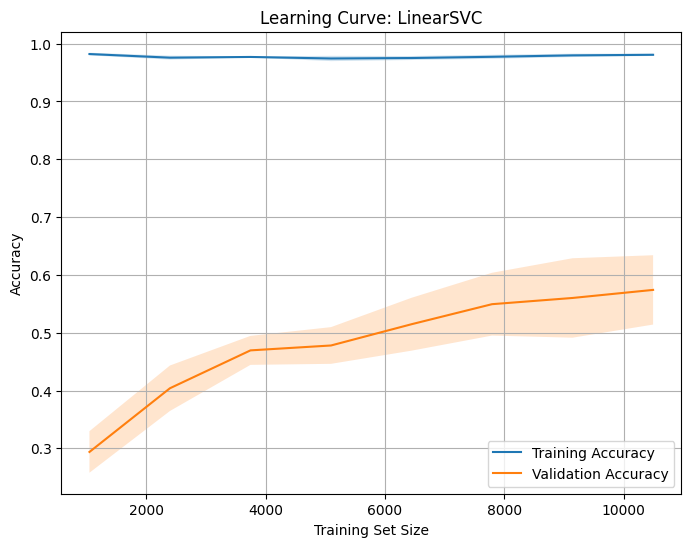

In [26]:
#Visualizing SVC
plot_learning_curve(svc_model_real, "Learning Curve: LinearSVC", X_svc, y_svc)



## Summary Table of Model Results

In [27]:
import time
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# -----------------------------------
# 1. Data Preparation
# -----------------------------------

# Real data
X_real = df_subset["text_clean"]
y_real = df_subset["Combined_ipc_clean"]

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, stratify=y_real, random_state=42
)

# Synthetic data (assumes X_syn, y_syn already generated)
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, stratify=y_syn, random_state=42
)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    t0 = time.time()
    preds = model.predict(X_test)
    test_time = time.time() - t0

    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")

    return acc, macro_f1, train_time, test_time

vec = CountVectorizer(stop_words="english", max_features=50000)

vec.fit(pd.concat([X_train_real, X_train_syn]))

# Transform datasets
X_train_real_vec = vec.transform(X_train_real)
X_test_real_vec = vec.transform(X_test_real)
X_train_syn_vec = vec.transform(X_train_syn)
X_test_syn_vec = vec.transform(X_test_syn)

#train and evaluate models on the synthetic data and the real data so we can make summary table

results = []

# CNB - Real
cnbr = ComplementNB()
acc, f1, t_train, t_test = evaluate_model(cnbr, X_train_real_vec, y_train_real, X_test_real_vec, y_test_real)
results.append(["REAL", "CNB", acc, f1, t_train, t_test])

# SVC--Real
svcr = LinearSVC()
acc, f1, t_train, t_test = evaluate_model(svcr, X_train_real_vec, y_train_real, X_test_real_vec, y_test_real)
results.append(["REAL", "SVC", acc, f1, t_train, t_test])

# CNB - Synthetic
cnbs = ComplementNB()
acc, f1, t_train, t_test = evaluate_model(cnbs, X_train_syn_vec, y_train_syn, X_test_syn_vec, y_test_syn)
results.append(["SYNTHETIC", "CNB", acc, f1, t_train, t_test])

# SVC - Synthetic
svcs = LinearSVC()
acc, f1, t_train, t_test = evaluate_model(svcs, X_train_syn_vec, y_train_syn, X_test_syn_vec, y_test_syn)
results.append(["SYNTHETIC", "SVC", acc, f1, t_train, t_test])

#create the summary table

summary_df = pd.DataFrame(
    results,
    columns=["Dataset", "Model", "Accuracy", "Macro-F1", "Train Time (s)", "Test Time (s)"]
)
#round to 4 like in appendix tables
summary_df[["Accuracy", "Macro-F1", "Train Time (s)", "Test Time (s)"]] = summary_df[["Accuracy", "Macro-F1", "Train Time (s)", "Test Time (s)"]].round(4)

print("==== Summary Table for All Experiments ====")
print(tabulate(summary_df, headers='keys', tablefmt='grid'))


==== Summary Table for All Experiments ====
+----+-----------+---------+------------+------------+------------------+-----------------+
|    | Dataset   | Model   |   Accuracy |   Macro-F1 |   Train Time (s) |   Test Time (s) |
+====+===========+=========+============+============+==================+=================+
|  0 | REAL      | CNB     |     0.6954 |     0.524  |           0.0477 |          0.0179 |
+----+-----------+---------+------------+------------+------------------+-----------------+
|  1 | REAL      | SVC     |     0.7202 |     0.6139 |           4.1708 |          0.0085 |
+----+-----------+---------+------------+------------+------------------+-----------------+
|  2 | SYNTHETIC | CNB     |     0.503  |     0.0993 |           0.0518 |          0.0062 |
+----+-----------+---------+------------+------------+------------------+-----------------+
|  3 | SYNTHETIC | SVC     |     0.476  |     0.092  |           0.765  |          0.0029 |
+----+-----------+---------+--------

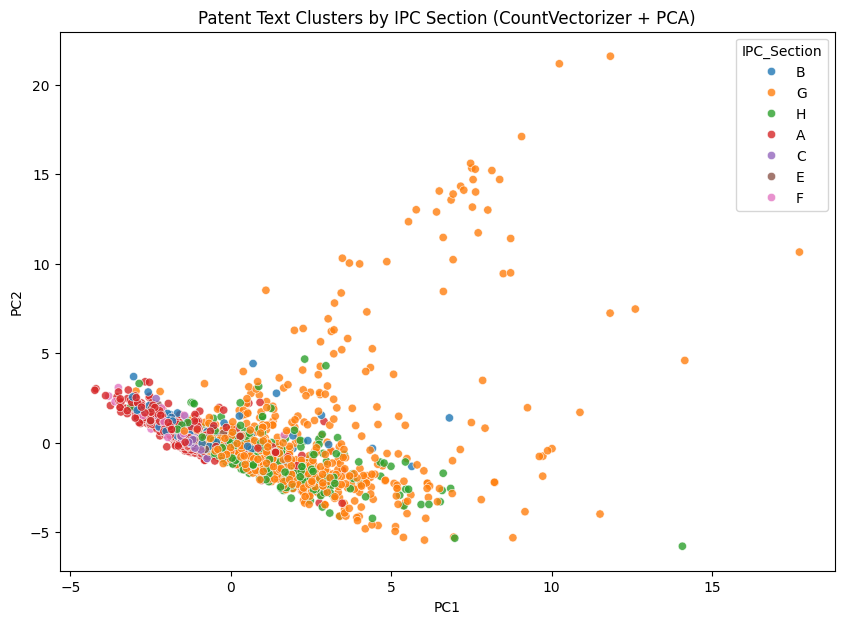

In [28]:
# Additional SVC plots
def normalize_ipc_label(label: str) -> str:
    # Handle composite labels (e.g., H;G:06) by taking the first section
    if ";" in label:
        label = label.split(";")[0]

    # Extract the IPC Section (A, B, C...)
    match = re.search(r"^[A-H]", label)  # IPC sections go from A to H
    if match:
        return match.group(0)

    return "UNKNOWN"

# Normalize the labels with the function above
y_sections = [normalize_ipc_label(lbl) for lbl in y_test_svc]

# Vectorize text using CountVectorizer
# UPDATE: Swapped TF-IDF for CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words="english")
X_counts = vectorizer.fit_transform(X_test_svc)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
# UPDATE: transform the counts, not tfidf
X_2d = pca.fit_transform(X_counts.toarray())

# Create DataFrame for plotting
pca_df = pd.DataFrame({"PC1": X_2d[:, 0], "PC2": X_2d[:, 1], "IPC_Section": y_sections})

# plot everything together first to see overall clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="IPC_Section", palette="tab10", alpha=0.8
)

plt.title("Patent Text Clusters by IPC Section (CountVectorizer + PCA)")
plt.show()

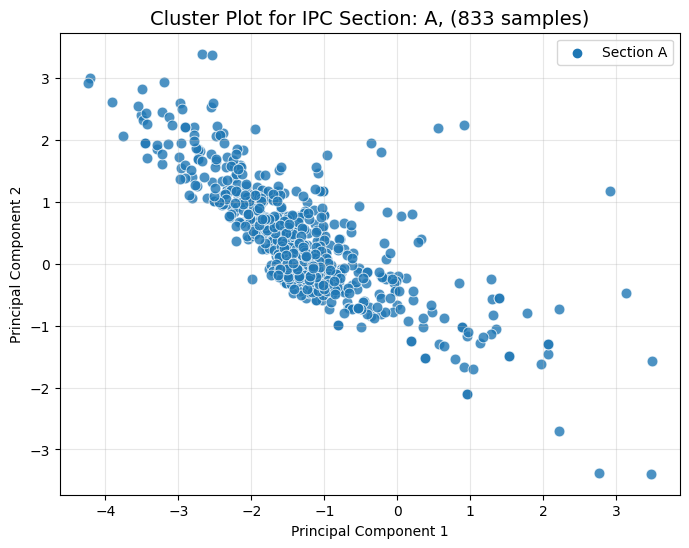

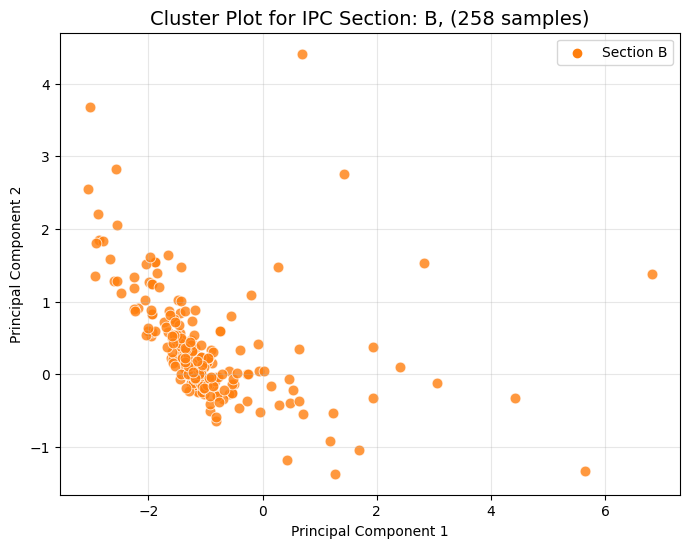

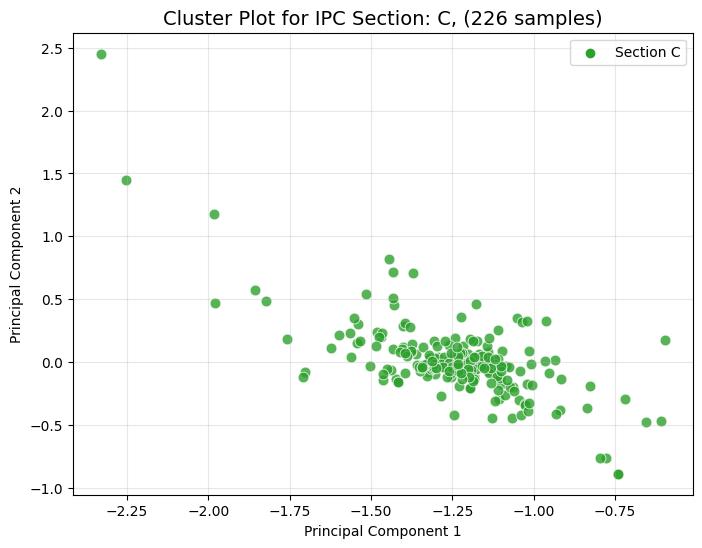

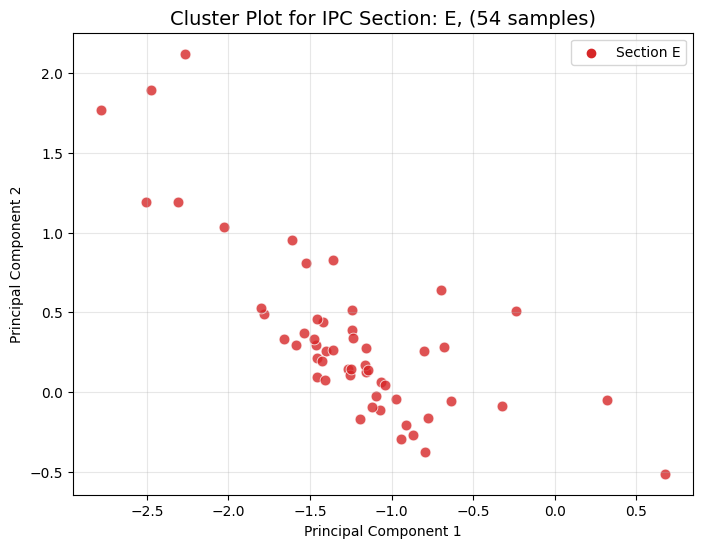

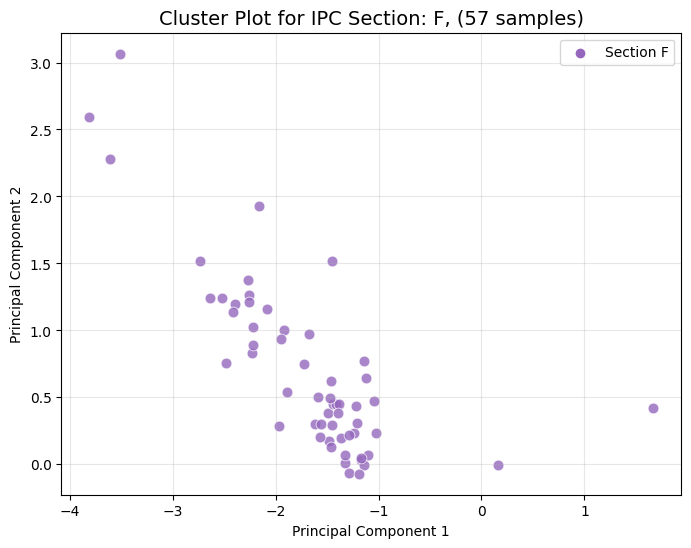

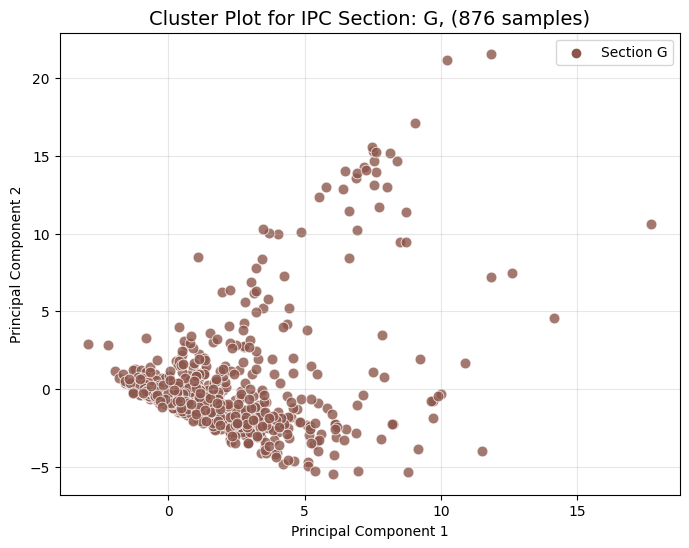

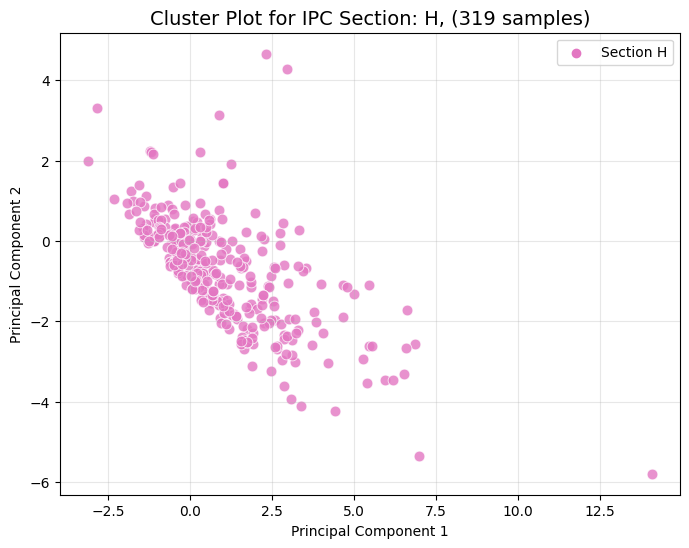

In [29]:
# now let's plot each section separately

unique_sections = sorted(pca_df["IPC_Section"].unique())
palette = sns.color_palette("tab10", len(unique_sections))
color_map = {sec: palette[i] for i, sec in enumerate(unique_sections)}

# 6. Plot each section separately using its assigned color
for section in unique_sections:
    pca_df_subset = pca_df[pca_df["IPC_Section"] == section]
    count = (pca_df_subset["IPC_Section"] == section).sum()
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=pca_df_subset, x="PC1", y="PC2", s=60, alpha=0.8, color=color_map[section]
    )

    plt.title(
        f"Cluster Plot for IPC Section: {section}, ({count} samples)",
        fontsize=14,
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)

    # Show legend with single color
    plt.scatter([], [], color=color_map[section], label=f"Section {section}")
    plt.legend()

    plt.show()

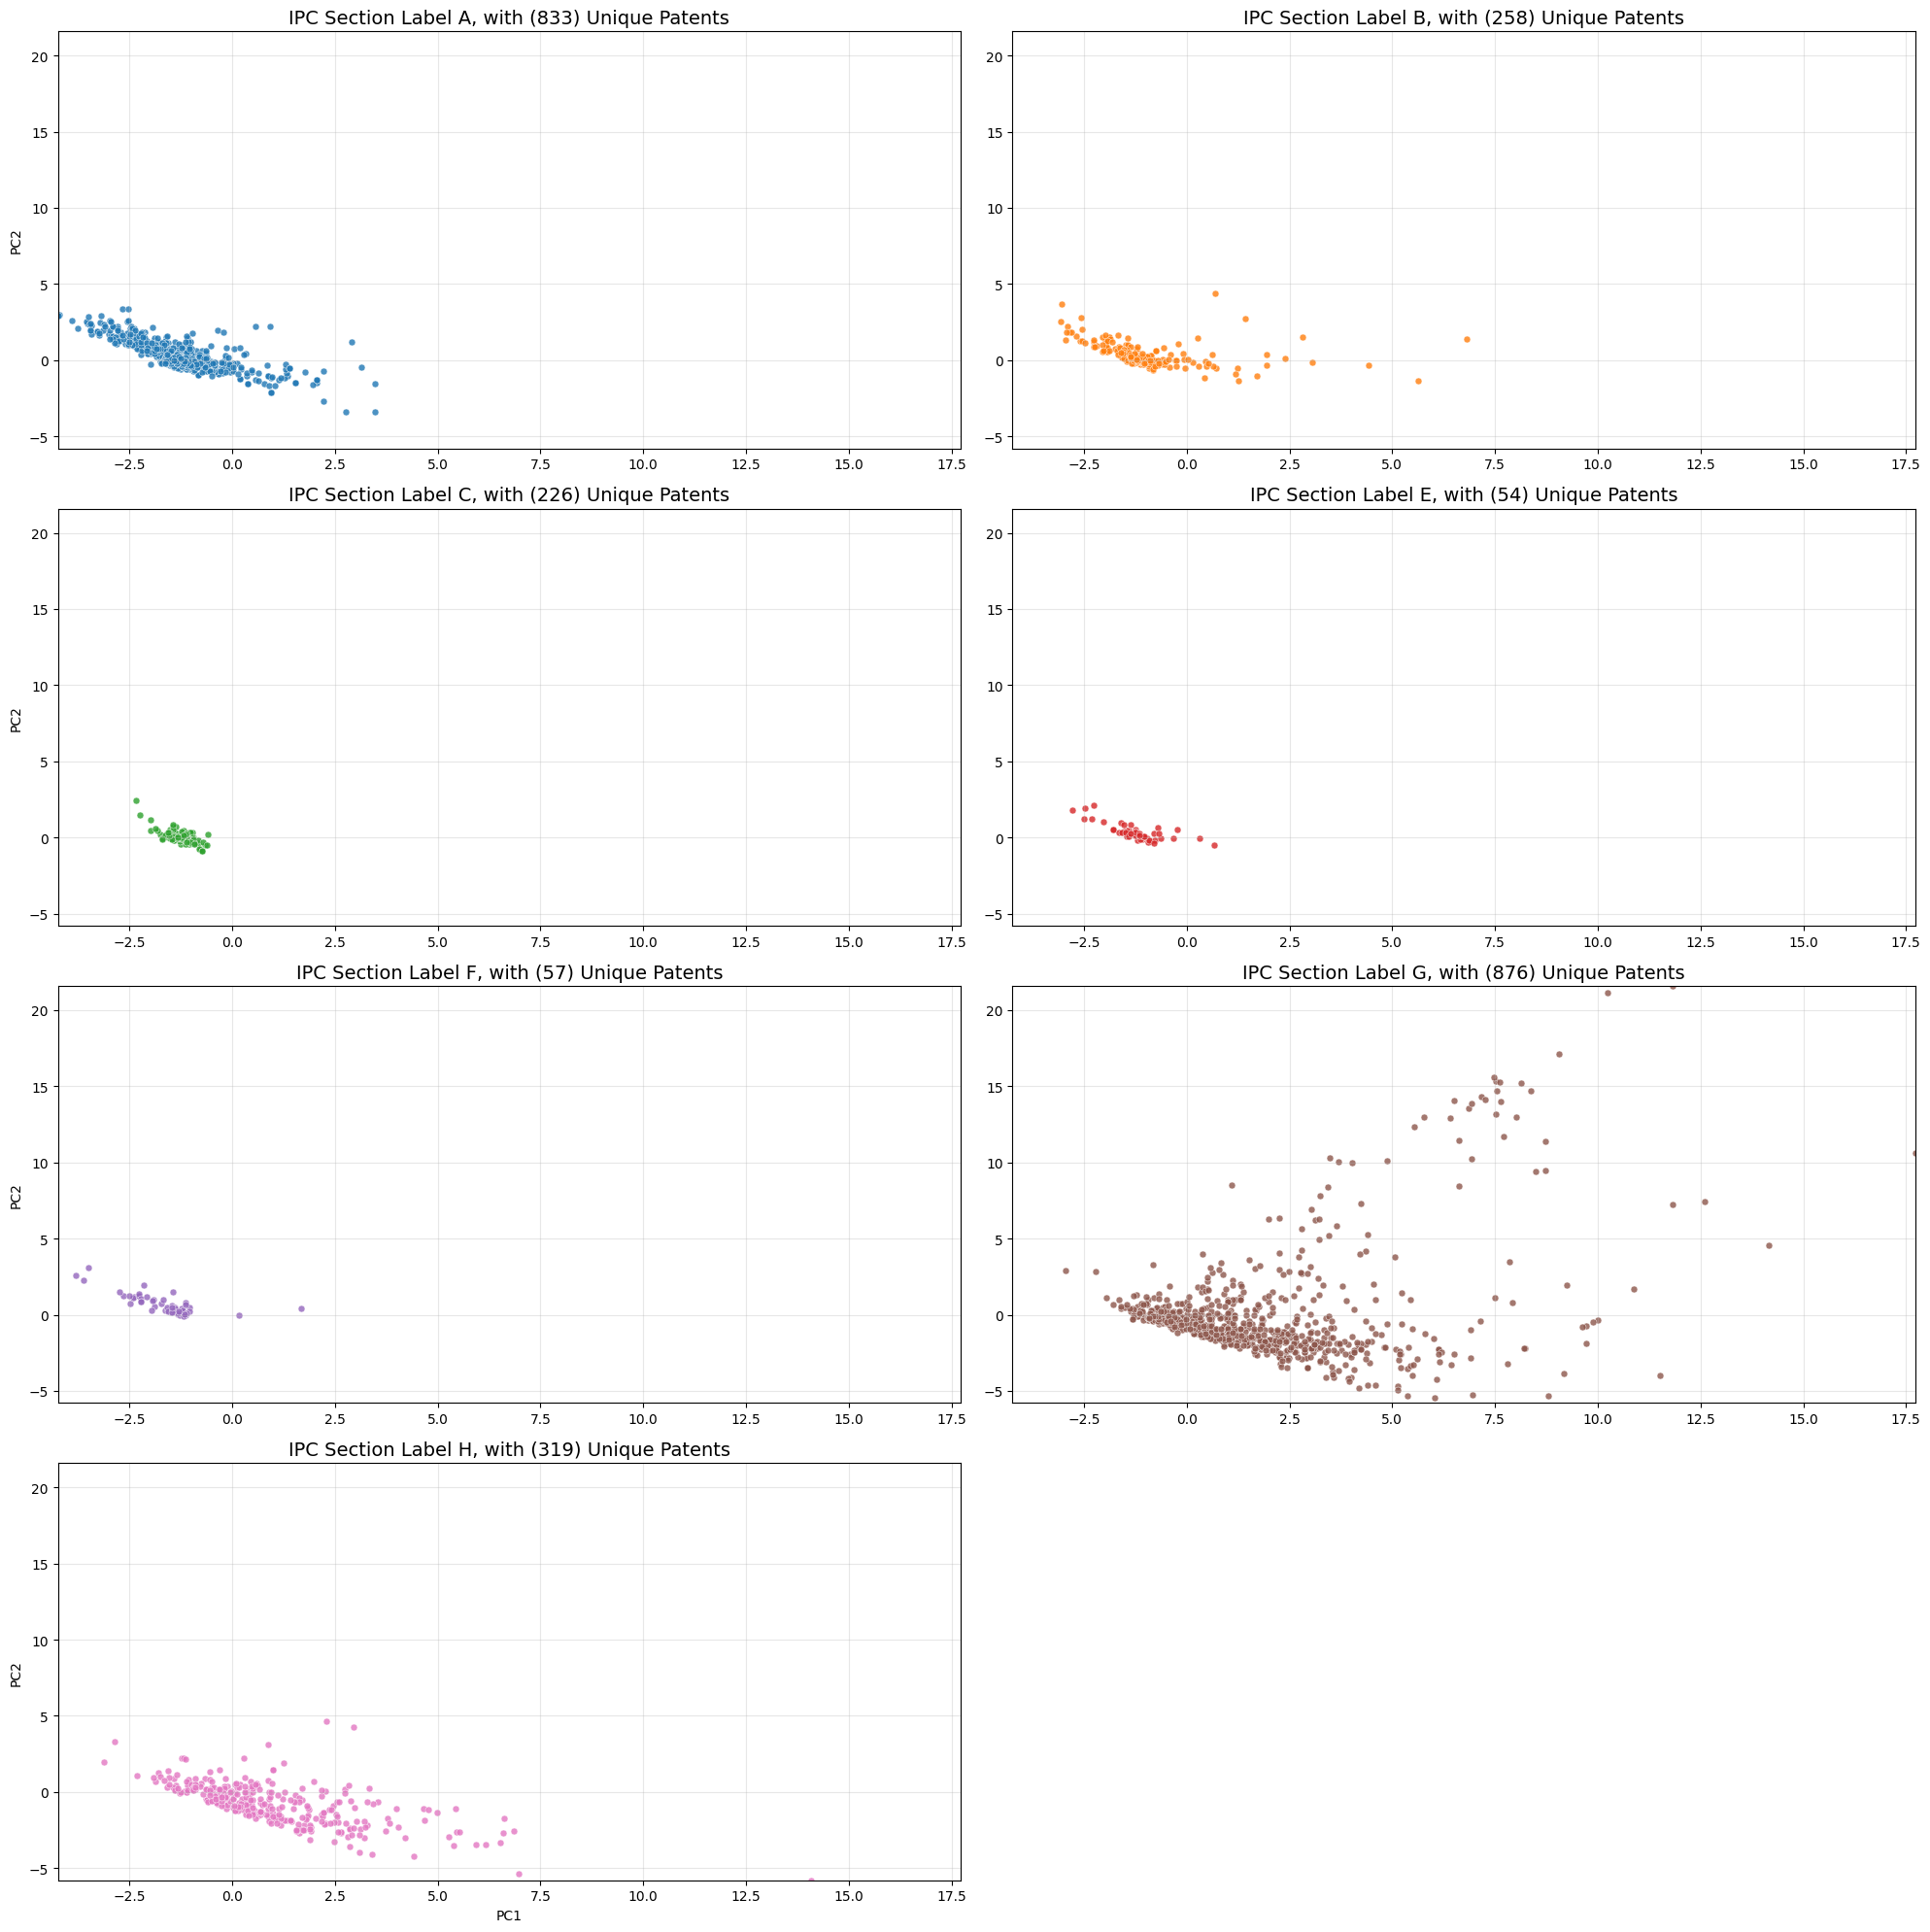

In [30]:
palette = sns.color_palette("tab10", len(unique_sections))
color_map = {sec: palette[i] for i, sec in enumerate(unique_sections)}

# Shared axes limits (FIXED: use pca_df, not df)
x_min, x_max = pca_df["PC1"].min(), pca_df["PC1"].max()
y_min, y_max = pca_df["PC2"].min(), pca_df["PC2"].max()

n = len(unique_sections)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, section in enumerate(unique_sections):
    ax = axes[i]
    # FIXED: use pca_df here
    df_sub = pca_df[pca_df["IPC_Section"] == section]

    sns.scatterplot(
        data=df_sub, x="PC1", y="PC2", s=25, alpha=0.8, color=color_map[section], ax=ax
    )

    ax.set_title(
        f"IPC Section Label {section}, with ({len(df_sub)}) Unique Patents", fontsize=14
    )
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Pros and Cons of the Solution:

**Complement Naive Bayes Classifier:**
The ComplementNB classifier was chosen because this variant of the Naive Bayes algorithm performs better on imbalanced datasets and text classification problems than the standard Multinomial Naive Bayes algorithm. This is important in contexts like patent classification, where IPC sections and labels for subsidiary patents appear much more frequently than others, or patents fall into multiple categories. The time difference between the two models was marginal, each taking only 1-2 seconds to run. However, some factors pose difficulties when using the ComplementNB classifier. 

Additionally, Naive Bayes does not take into account word order, grammar rules, or common phrases. It treats input text simply like a bag of words and ignores human language rules. ComplementNB can only learn from words it has seen and is highly dependent on tokenization and preprocessing. The bag of words approach can hinder model performance, as evidenced by potential misclassifications where documents contain similar vocabulary but differ in technical function, resulting in the model grouping them into the same IPC class despite their conceptual differences. This is critical to patent classification because abstracts often contain domain-specific terms, which may be down-weighted if preprocessing doesn’t take it into account. In our model, this is evidenced by improved accuracy scores after iterations of data cleaning steps, including lemmatization and stop-word removal, which shows the model’s dependence on careful feature engineering. 

**Support Vector Classifier:**


## Appendix

### Tables for Experiment with Real Data

**Complement Naive Bayes Classifier**

In [31]:
print("Real Data Results (CountVectorizer):")
print(tabulate(report_df_real_cnb, headers='keys', tablefmt='grid'))

Real Data Results (CountVectorizer):
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0      |   0      |     0      |   13      |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      0.4462 |   0.8447 |     0.5839 |  103      |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      0.7541 |   0.6301 |     0.6866 |   73      |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      0.5    |   0.0909 |     0.1538 |   11      |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0.8333 |   0.8333 |     0.8333 |   12      |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.8475 |   0.9804 |     0.9091 |   51      |
+--------------+---------

**Support Vector Classifier**


In [32]:
print("Real Data Results - SVC (CountVectorizer):")
print(tabulate(report_df_real_svc, headers='keys', tablefmt='grid'))

Real Data Results - SVC (CountVectorizer):
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0.1765 |   0.2308 |     0.2    |   13      |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      0.6068 |   0.6893 |     0.6455 |  103      |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      0.7024 |   0.8082 |     0.7516 |   73      |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      1      |   0.6364 |     0.7778 |   11      |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0.9    |   0.75   |     0.8182 |   12      |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.8772 |   0.9804 |     0.9259 |   51      |
+--------------+---